In [2]:
import sys 
sys.path.append('../../RenderMan/Builds/LinuxMakefile/build/')
sys.path.append('../../dexed/Builds/Linux/build/')


In [3]:
import librenderman as rm
import numpy as np
import scipy.optimize as optimize
from IPython.display import Audio

import librosa
import librosa.display
import librosa.core.pitch

import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../')
import pitch_detection as pitch_detection; reload(pitch_detection)

%matplotlib inline

/home/peterp/miniconda2/envs/py2synth/lib/python2.7/site-packages/librosa/__init__.py:35: FutureWarning: You are using librosa with Python 2. Please note that librosa 0.7 will be the last version to support Python 2, after which it will require Python 3 or later.
  FutureWarning)


In [4]:
from aubio import source, pitch
sys.path.append('/home/peterp/synthi/aubio/python/demos/')

In [5]:
# Important settings. These are good general ones.
sampleRate = 44100
bufferSize = 512
fftSize = 512

# This will host a VST. It will render the features and audio we need.
engine = rm.RenderEngine(sampleRate, bufferSize, fftSize)

# Load the VST into the RenderEngine.
path = "../../dexed/Builds/Linux/build/Dexed.so"
path = "../../amsynth-1.8.0/.libs/amsynth_vst.so"
engine.load_plugin(path)

# Create a patch generator. We can initialise it to generate the correct
# patches for a given synth by passing it a RenderEngine which has
# loaded a instance of the synthesiser. 
generator = rm.PatchGenerator(engine)

# We can also get a string of information about the
# available parameters.
#print engine.get_plugin_parameters_description()
paramsDict = engine.get_plugin_parameters_description()
paramsDict = {p.split(':')[1].strip():int(p.split(':')[0].strip()) for p in paramsDict.split('\n')[:-1]}
print paramsDict

{'filter_vel_sens': 38, 'amp_decay': 1, 'osc2_range': 17, 'filter_kbd_track': 37, 'filter_env_amount': 10, 'amp_release': 3, 'lfo_waveform': 16, 'filter_sustain': 7, 'filter_mod_amount': 20, 'portamento_time': 31, 'filter_cutoff': 11, 'portamento_mode': 40, 'reverb_damp': 26, 'osc2_detune': 12, 'osc_mix': 18, 'osc2_pulsewidth': 24, 'lfo_freq': 15, 'osc_mix_mode': 22, 'filter_slope': 35, 'distortion_crunch': 29, 'osc1_pulsewidth': 23, 'amp_sustain': 2, 'osc2_pitch': 33, 'keyboard_mode': 32, 'filter_type': 34, 'freq_mod_amount': 19, 'reverb_width': 28, 'freq_mod_osc': 36, 'filter_release': 8, 'reverb_roomsize': 25, 'master_vol': 14, 'osc1_waveform': 4, 'reverb_wet': 27, 'amp_mod_amount': 21, 'osc2_waveform': 13, 'amp_attack': 0, 'amp_vel_sens': 39, 'filter_resonance': 9, 'filter_attack': 5, 'filter_decay': 6, 'osc2_sync': 30}


In [6]:
# Settings to play a note and extract data from the synth.
midiNote = 80
midiVelocity = 127
noteLength = 0.5
renderLength = 0.5
n_mfcc = 15

fixedParams_raw={'filter_vel_sens': 0, 'amp_decay': 0, 'osc2_range': 0,
             'filter_kbd_track': 0, 'filter_env_amount': 1, 'amp_release': 0,
             'lfo_waveform': 0, 'filter_sustain': 1, 'filter_mod_amount': 1,
             'portamento_time': 1, 'filter_cutoff': 0, 'portamento_mode': 1,
             'reverb_damp': 0, 'osc2_detune': 0, 'osc_mix': 0.5, 'osc2_pulsewidth': 0,
             'lfo_freq': 0, 'osc_mix_mode': 1, 'filter_slope': 1, 'distortion_crunch': 0,
             'osc1_pulsewidth': 0, 'amp_sustain': 1, 'osc2_pitch': 0, 'keyboard_mode': 1,
             'filter_type': 0, 'freq_mod_amount': 0, 'reverb_width': 0, 'freq_mod_osc': 0,
             'filter_release': 0, 'reverb_roomsize': 0, 'master_vol': 1, 'osc1_waveform': 0,
             'reverb_wet': 0, 'amp_mod_amount': 0, 'osc2_waveform': 0, 'amp_attack': 0,
             'amp_vel_sens': 0, 'filter_resonance': 0, 'filter_attack': 0,
             'filter_decay': 0, 'osc2_sync': 0}


In [36]:
def wrapSynth(xParams, getAudio=False):
    
    for key,value in fixedParams.items():
        engine.override_plugin_parameter(paramsDict[key], value)
        
    for key,value in zip(dynParams,xParams):
        engine.override_plugin_parameter(paramsDict[key], value)
    
    engine.render_patch(midiNote, midiVelocity, noteLength, renderLength)

    # Get the data. Note the audio is automattically made mono, no
    # matter what channel size for ease of use.
    audio = engine.get_audio_frames()
    if getAudio:
        return audio
    
    return get_something(audio)
    
    
def metric(xParams):
    test = wrapSynth(xParams)
    return np.linalg.norm(test.flatten()-targetMetric.flatten())

In [50]:
np.random.seed(89)
midiNote = 80

def get_timbre(audio):
    S = librosa.feature.melspectrogram(y=np.array(audio), sr=sampleRate, n_mels=n_mfcc)
    snapshot_mfcc = S[:,5]
    snapshot_mfcc = (snapshot_mfcc - np.mean(snapshot_mfcc)) / np.std(snapshot_mfcc)
    return snapshot_mfcc

def get_envelope(audio):
    S = librosa.feature.melspectrogram(y=np.array(audio), sr=sampleRate, n_mels=n_mfcc)
    time_evol = np.nanmean(S, axis=0)
    time_evol = (time_evol - np.mean(time_evol)) / np.std(time_evol)
    return time_evol

def get_wabble(audio):
    S = librosa.feature.melspectrogram(y=np.array(audio), sr=sampleRate, n_mels=n_mfcc)
    time_evol = S[np.argmax(S[:,3]),4:-4]
    time_evol = (time_evol - np.mean(time_evol)) / np.std(time_evol)
    return time_evol

def get_full(audio):
    S = librosa.feature.melspectrogram(y=np.array(audio), sr=sampleRate, n_mels=n_mfcc)
    return S
    #return S

searching_dict = {
    1 : {'name':'timbre', 'get_mode':get_timbre,'dynParams':['osc_mix','osc2_pitch','filter_cutoff','osc1_waveform','filter_resonance',
           'osc2_range','osc2_waveform'],
               'iterations':3},
#    2 : {'get_mode':'envelope','dynParams':['amp_attack','amp_decay'],
#                 'iterations':3},
    3 : {'name':'wabble', 'get_mode':get_wabble, 'dynParams':['lfo_waveform','lfo_freq','freq_mod_osc'],
                 'iterations':3},
}

dynParams = []
for key,val in searching_dict.items():
    dynParams += val['dynParams']
print dynParams

fixedParams = fixedParams_raw.copy()

tParams = np.random.uniform(size=len(dynParams))

print(tParams)
target = wrapSynth(tParams, getAudio=True)

Audio(target, rate=sampleRate, autoplay=True)

['osc_mix', 'osc2_pitch', 'filter_cutoff', 'osc1_waveform', 'filter_resonance', 'osc2_range', 'osc2_waveform', 'lfo_waveform', 'lfo_freq', 'freq_mod_osc']
[0.49969432 0.25593713 0.25810063 0.09692171 0.56418511 0.01599007
 0.15259523 0.48024773 0.09987276 0.41696389]


In [48]:
for key,val in searching_dict.items():
    print('Fitting '+val['name'])

    get_something = val['get_mode']
    dynParams = val['dynParams']
    targetMetric = get_something(target)

    bounds = [(0,1) for p in range(len(dynParams))]
    popt = optimize.differential_evolution(metric,bounds,mutation=(1.0,1.2), 
                                           workers=1,maxiter=val['iterations'], disp=True)

    val['popt'] = popt
    val['fitted'] = {key:val for key,val in zip(dynParams,popt.x)}
    val['outMetric'] = wrapSynth(popt.x, getAudio=False)

    fixedParams.update(val['fitted'])
    
    print(val['fitted'])

Fitting timbre
differential_evolution step 1: f(x)= 0.188417
differential_evolution step 2: f(x)= 0.156656
differential_evolution step 3: f(x)= 0.113346
{'osc1_waveform': 0.5130719942764973, 'osc2_range': 0.016655505695900234, 'filter_cutoff': 0.889171316013428, 'osc2_pitch': 0.31722279707377954, 'osc2_waveform': 0.36315234482092384, 'osc_mix': 0.20053174660594922, 'filter_resonance': 0.5867299836417149}
Fitting envelope
differential_evolution step 1: f(x)= 3.83116
differential_evolution step 2: f(x)= 3.73478
differential_evolution step 3: f(x)= 3.73478
{'lfo_waveform': 0.2754578699981926, 'lfo_freq': 0.7680362159129888, 'freq_mod_osc': 0.21959882626791838}


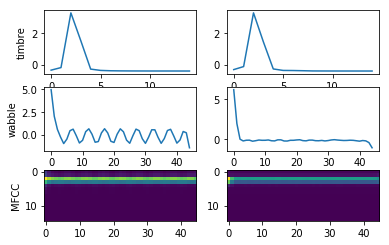

In [49]:
audio = wrapSynth(popt.x, getAudio=True)

fig, axes = plt.subplots(nrows=3, ncols=2)
for row,feature,key in zip(range(2), [get_mfccs,get_wabble], ['timbre','wabble']):
    axes[row,0].set_ylabel(key)
    axes[row,0].plot(feature(target))
    axes[row,1].plot(feature(audio))

axes[2,0].set_ylabel('MFCC')
axes[2,0].imshow(get_full(target))
axes[2,1].imshow(get_full(audio))
plt.show()

Audio(audio, rate=sampleRate, autoplay=True)

In [58]:
Audio(target, rate=sampleRate, autoplay=True)

In [ ]:
tParams = np.random.uniform(size=len(dynParams))
print(tParams)
tParams = [0.5, 0.5, 0.5, 0.6, 0.5, 0.5, 0.2]
target = wrapSynth(tParams, getAudio=True)
targetMfccs = get_mfccs(target)
Audio(target, rate=sampleRate, autoplay=True)


In [ ]:
filename = '../air_horn_1.mp3'
times,pitches,confidences = pitch_detection.get_pitch(filename)
midiNote = int(round(pitches[np.argmin(times)]))
print midiNote

target, sampleRate = librosa.load(filename)
targetMfccs = get_mfccs(target)
Audio(target, rate=sampleRate, autoplay=True)

In [ ]:
spezial_bounds = {
    'osc1_waveform':(0.,0.6),
    'osc2_waveform':(0.,0.6),    
}

bounds = [(0,1) for p in range(len(dynParams))]

for i,key in enumerate(dynParams):
    if key in spezial_bounds.keys():
        bounds[i] = spezial_bounds[key]
    
for key, val in zip(dynParams,bounds):
    print key, val
    
popt = optimize.differential_evolution(metric,bounds,mutation=(1.0,1.2), workers=1,maxiter=20, 
                                       disp=True)#, strategy='rand1exp')

In [ ]:
print popt.x
audio = wrapSynth(popt.x, getAudio=True)
audioMfccs = wrapSynth(popt.x, getAudio=False)
Audio(audio, rate=sampleRate, autoplay=True)

In [ ]:
fig, axes = plt.subplots(ncols=2)
axes[0].plot(targetMfccs)
axes[1].plot(audioMfccs)
for ax in axes:
    ax.axvline(x = n_mfcc, color='gray', linestyle='--')
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=1)

ax.plot(popt.x)
ax.set_xticks(range(len(dynParams)))
ax.set_xticklabels(dynParams)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()
print(dynParams)

In [ ]:
pitches,magnitudes = librosa.core.pitch.piptrack(target, sr=sampleRate)

def detect_pitch(y, sr, t):
  index = magnitudes[:, t].argmax()
  pitch = pitches[index, t]

  return pitch

pitch_freq = detect_pitch(target, sampleRate, 1)
midiNote = int(np.round(np.log2(pitch_freq / 440.)*12 + 69.))
print(pitch_freq,midiNote)